In [2]:
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl

import geopandas
import geoplot
import geoplot.crs as gcrs

import rasterio
import rioxarray

import json
import seaborn as sns

In [3]:
adm_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\hvstat_africa_boundary_v1.0.gpkg')

In [5]:
adm_data = adm_data.loc[adm_data['ADMIN0'] == 'Kenya']

In [7]:
len(adm_data)

47

In [8]:
yield_data = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\hvstat_africa_data.csv')
yield_data = yield_data.loc[(yield_data['product'] == 'Maize')]
kenya_data = yield_data.loc[yield_data['country'] == 'Kenya']

In [10]:
kenya_data['planting_month'].unique()

array([ 1,  3, 10])

In [34]:
adm_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\adm_boundaries.geojson')
adm_data = adm_data.loc[adm_data['name'] != 'Kenya']
adm_data = adm_data.loc[adm_data['unit_type'] == 'Admin 1']
adm_data.drop(columns = ['end_date', 'country_code', 
                         'fewsnet_region', 'geographic_group', 
                         'es_name', 'fr_name', 'pt_name',
                         'ar_name', 'country', 'admin_0',
                         'admin_3', 'admin_4', 'layer_id',
                         'geographicunitsetversion_name', 'zone_type', 'urban_rural', 'start_month',
                         ], inplace=True)
#adm_data = adm_data.explode()#.crs
adm_data.loc[:, 'centroid'] = adm_data.loc[:, 'geometry'].to_crs(crs=3857).centroid.to_crs('EPSG:4326')
adm_data_for_merging = adm_data.drop_duplicates(subset = ['admin_1']).drop(columns=['fnid', 'admin_2', 'start_date', 'id'])
yield_data_polygons = adm_data_for_merging.merge(kenya_data, on=['admin_1'], how='right')#yield_data.merge(, on=['fnid'], how='left')#, validate='one_to_many')

Skipping field centroid: unsupported OGR type: 3


In [4]:
yield_data_polygons.loc[(yield_data_polygons['name'] == adm1_name)*(yield_data_polygons['planting_year'] == 2003)]

NameError: name 'adm1_name' is not defined

In [5]:
yield_data_mean = yield_data.loc[(yield_data['country'] == 'Kenya')].dropna()
yield_data_mean = yield_data_mean.loc[:, ['admin_1', 'yield']].groupby('admin_1').mean()
yield_data_mean = adm_data_for_merging.merge(yield_data_mean, left_on=['name'], right_on = ['admin_1'], how='right')

In [6]:
clipped = xds['t2m'].isel(time=10).rio.clip(yield_data_mean.iloc[[30], :].geometry.values, yield_data_mean.crs, all_touched = True, drop=False)#adm_data.iloc[10, :].geometry.exterior.coords

NameError: name 'xds' is not defined

In [7]:
region_data_list = []
for region_index in list(range(1, 21)) + list(range(22, 50)):
    print(region_index)
    adm1_name = yield_data_mean.iloc[region_index, 1]
    print(adm1_name)
    clipped = xr.open_dataset(f'C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Temp\\{adm1_name}_1999_2008.nc')#rioxarray.open_rasterio(f'C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Temp\\{adm1_name}_1999_2008.nc')
    for year in range(1999, 2009):
        #acc_temp = clipped['t2m'].sel(time=slice(f'{year}-03-01', f'{year}-06-30')).sum(dim='time').mean().values
        acc_temp = clipped['t2m'].sel(time=slice(f'{year}-03-01', f'{year}-06-30')).sum(dim='time').mean().values
        print(acc_temp)# - 273.15*122)
        yield_data_polygons.loc[(yield_data_polygons['name'] == adm1_name)*(yield_data_polygons['planting_year'] == year), 'acc_temp'] = acc_temp#clipped['t2m'].isel(time=slice(48, 170)).sum().values - 273.15*122
    #region_data_list.append(clipped)
    #print(len(yield_data_polygons.loc[(yield_data_polygons['name'] == adm1_name)*(yield_data_polygons['planting_year'] == 2003)]))

1
Bomet
1571.373779296875
1664.11962890625
1561.21240234375
1599.9482421875
1631.296875
1585.252197265625
1618.956298828125
1571.9921875
1592.6484375
1584.2303466796875
2
Bungoma
1232.8199462890625
1266.256591796875
1218.4566650390625
1260.0560302734375
1277.538818359375
1260.9434814453125
1281.043701171875
1236.5738525390625
1269.7174072265625
1246.5897216796875
3
Busia
1432.390869140625
1464.9283447265625
1439.05810546875
1454.3299560546875
1473.1866455078125
1470.1002197265625
1479.81396484375
1437.519775390625
1478.3482666015625
1442.40966796875
4
Elgeyo-Marakwet
1361.6787109375
1395.9639892578125
1324.5916748046875
1343.510009765625
1368.1038818359375
1346.2086181640625
1364.2279052734375
1362.802978515625
1358.873291015625
1366.13134765625
5
Embu
1761.7801513671875
1802.135498046875
1786.1551513671875
1755.4290771484375
1814.940185546875
1784.356689453125
1817.5382080078125
1785.04296875
1818.359375
1774.2174072265625
6
Garissa
1560.3646240234375
1566.1905517578125
1589.756347656

In [11]:
clipped

<xarray.Dataset> Size: 8MB
Dimensions:      (x: 11, y: 17, time: 3653)
Coordinates:
  * x            (x) float64 88B 34.8 34.9 35.0 35.1 ... 35.5 35.6 35.7 35.8
  * y            (y) float64 136B 2.7 2.6 2.5 2.4 2.3 ... 1.5 1.4 1.3 1.2 1.1
  * time         (time) datetime64[ns] 29kB 1999-01-01 1999-01-02 ... 2008-12-31
Data variables:
    spatial_ref  int64 8B ...
    t2m          (time, y, x) float32 3MB ...
    t2max        (time, y, x) float32 3MB ...
    t2min        (time, y, x) float32 3MB ...
Attributes: (12/32)
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            fc
    GRIB_gridDefinitionDescription:           Latitude/Longitude Grid
    GRIB_gridType:                            regular_ll
    GRIB_iDirectionIncrementInDegrees:        0.1
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    GRIB_uvRelativeToGrid:                    0
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

<Axes: xlabel='acc_temp', ylabel='yield'>

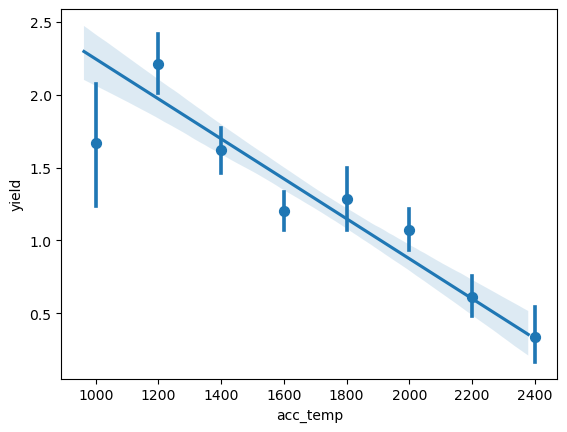

In [10]:
for_corr = yield_data_polygons.dropna(subset = ['acc_temp'])
for_corr = for_corr.loc[for_corr['acc_temp'] > 0, :]
sns.regplot(data=for_corr, x='acc_temp', y='yield', x_bins=np.arange(1000, 2500, 200))

In [ ]:
temp_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\temp_SSA_1999_2008.nc')
xds = rioxarray.open_rasterio('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\temp_SSA_1999_2008.nc')
xds = xds.rio.write_crs('EPSG:4326')

In [52]:
xds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\Kenya_ERA5_2000_2024_with_dates2.nc')
xds = xds.drop_vars(['start_date_early', 'start_date', 'harvest_date_early', 'harvest_date', 'start_date2_early', 'start_date2', 'harvest_date2_early', 'harvest_date2'])

In [55]:
for region_index in range(2, 3):
    print(region_index)
    adm1_name = adm_data.iloc[region_index, 9]
    print(adm1_name)
    clipped = xds.rio.clip(adm_data.iloc[[region_index], :].geometry.values, adm_data.crs, all_touched = True, drop=True)

2
Kilifi


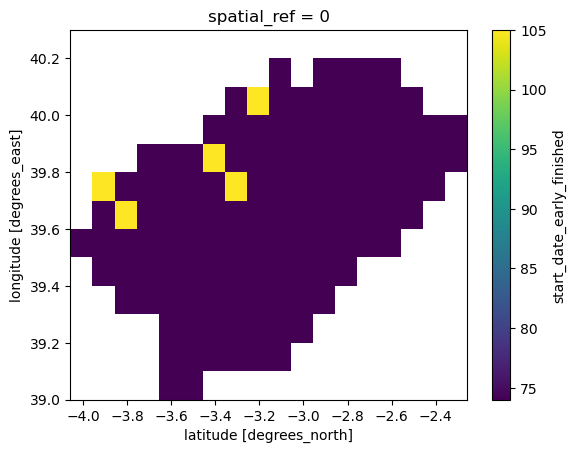

In [56]:
clipped['start_date_early_finished'].plot()

In [101]:
time_indexer = clipped['start_date_early_finished'].astype('timedelta64[D]')

In [102]:
#time_indexer = pd.to_timedelta(time_indexer.values, 'D') #time_indexer.rename('time').assign_attrs(time_units="days since 2000-01-01")

In [103]:
#np.timedelta64(np.array([[1, 2], [2, 3]]).astype(np.float64), 'D')

In [104]:
time_indexer

<xarray.DataArray 'start_date_early_finished' (x: 13, y: 18)> Size: 2kB
array([[  'NaT',   'NaT',   'NaT',   'NaT',   'NaT',   'NaT',   'NaT',
          'NaT',   'NaT',   'NaT',   'NaT',   'NaT', 6393600, 6393600,
          'NaT',   'NaT',   'NaT',   'NaT'],
       [  'NaT',   'NaT',   'NaT',   'NaT',   'NaT',   'NaT',   'NaT',
          'NaT', 6393600, 6393600, 6393600, 6393600, 6393600, 6393600,
          'NaT',   'NaT',   'NaT',   'NaT'],
       [  'NaT',   'NaT',   'NaT',   'NaT',   'NaT',   'NaT',   'NaT',
        6393600, 6393600, 6393600, 6393600, 6393600, 6393600, 6393600,
          'NaT',   'NaT',   'NaT',   'NaT'],
       [  'NaT',   'NaT',   'NaT',   'NaT',   'NaT',   'NaT', 6393600,
        6393600, 6393600, 6393600, 6393600, 6393600, 6393600, 6393600,
        6393600, 6393600,   'NaT',   'NaT'],
       [  'NaT',   'NaT',   'NaT',   'NaT',   'NaT', 6393600, 6393600,
        6393600, 6393600, 6393600, 6393600, 6393600, 6393600, 6393600,
        6393600, 6393600, 6393600,   'NaT'],
       [  'NaT',   'NaT',   'NaT', 6393600, 6393600, 6393600, 6393600,
        6393600, 6393600, 6393600, 6393600, 6393600, 6393600, 6393600,
        6393600, 6393600, 6393600, 6393600],
       [  'NaT',   'NaT', 6393600, 6393600, 6393600, 6393600, 6393600,
        6393600, 6393600, 6393600, 6393600, 6393600, 6393600, 6393600,
        6393600, 9072000, 6393600,   'NaT'],
       [  'NaT', 6393600, 6393600, 6393600, 6393600, 6393600, 6393600,
        6393600, 6393600, 6393600, 9072000, 6393600, 6393600, 6393600,
        6393600, 6393600, 9072000,   'NaT'],
       [6393600, 6393600, 6393600, 6393600, 6393600, 6393600, 6393600,
        6393600, 6393600, 6393600, 6393600, 9072000, 6393600, 6393600,
        6393600,   'NaT',   'NaT',   'NaT'],
       [6393600, 6393600, 6393600, 6393600, 6393600, 6393600, 6393600,
        6393600, 6393600, 6393600, 6393600, 6393600,   'NaT',   'NaT',
          'NaT',   'NaT',   'NaT',   'NaT'],
       [  'NaT',   'NaT', 6393600, 6393600, 6393600, 6393600, 6393600,
        6393600, 6393600, 9072000, 6393600,   'NaT',   'NaT',   'NaT',
          'NaT',   'NaT',   'NaT',   'NaT'],
       [  'NaT',   'NaT',   'NaT', 6393600, 6393600, 6393600, 6393600,
          'NaT', 6393600,   'NaT',   'NaT',   'NaT',   'NaT',   'NaT',
          'NaT',   'NaT',   'NaT',   'NaT'],
       [  'NaT',   'NaT',   'NaT',   'NaT',   'NaT',   'NaT',   'NaT',
          'NaT',   'NaT',   'NaT',   'NaT',   'NaT',   'NaT',   'NaT',
          'NaT',   'NaT',   'NaT',   'NaT']], dtype='timedelta64[s]')
Coordinates:
  * x            (x) float64 104B 39.05 39.15 39.25 39.35 ... 40.05 40.15 40.25
  * y            (y) float64 144B -2.307 -2.407 -2.507 ... -3.807 -3.907 -4.007
    spatial_ref  int64 8B 0

In [105]:
#xr.decode_cf(time_indexer) #- np.datetime64('2000-01-01')

In [106]:
#time_indexer{'units': 'hours since 2000-01-01'}

In [108]:
#time_indexer = pd.to_timedelta(time_indexer, 'D')

In [118]:
clipped.time

<xarray.DataArray 'time' (time: 9107)> Size: 73kB
array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
       '2000-01-03T00:00:00.000000000', ..., '2024-12-28T00:00:00.000000000',
       '2024-12-29T00:00:00.000000000', '2024-12-30T00:00:00.000000000'],
      shape=(9107,), dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 73kB 2000-01-01 2000-01-02 ... 2024-12-30
    spatial_ref  int64 8B 0

In [120]:
#time_indexer + np.datetime64('2000-01-01')

In [121]:
clipped.isel(time=0)

<xarray.Dataset> Size: 21kB
Dimensions:                            (x: 13, y: 18, bnds: 2)
Coordinates:
  * x                                  (x) float64 104B 39.05 39.15 ... 40.25
  * y                                  (y) float64 144B -2.307 -2.407 ... -4.007
    time                               datetime64[ns] 8B 2000-01-01
    spatial_ref                        int64 8B 0
Dimensions without coordinates: bnds
Data variables: (12/16)
    temperature_2m                     (x, y) float32 936B nan nan ... nan nan
    t2max                              (x, y) float32 936B nan nan ... nan nan
    t2min                              (x, y) float32 936B nan nan ... nan nan
    vpd                                (x, y) float32 936B nan nan ... nan nan
    surface_solar_radiation_downwards  (x, y) float32 936B nan nan ... nan nan
    total_precipitation                (x, y) float32 936B nan nan ... nan nan
    ...                                 ...
    harvest_date_early_finished        (x, y) float64 2kB nan nan ... nan nan
    harvest_date_late_finished         (x, y) float64 2kB nan nan ... nan nan
    start_date2_early_finished         (x, y) float64 2kB nan nan ... nan nan
    start_date2_late_finished          (x, y) float64 2kB nan nan ... nan nan
    harvest_date2_early_finished       (x, y) float64 2kB nan nan ... nan nan
    harvest_date2_late_finished        (x, y) float64 2kB nan nan ... nan nan
Attributes:
    date_range:  [ 347155200000 1640649600000]
    period:      0

In [119]:
clipped.sel(time = (time_indexer + np.datetime64('2000-01-01')).fillna(np.datetime64('2000-01-01')))

<xarray.Dataset> Size: 23kB
Dimensions:                            (x: 13, y: 18, bnds: 2)
Coordinates:
  * x                                  (x) float64 104B 39.05 39.15 ... 40.25
  * y                                  (y) float64 144B -2.307 -2.407 ... -4.007
    time                               (x, y) datetime64[ns] 2kB 2000-01-01 ....
    spatial_ref                        int64 8B 0
Dimensions without coordinates: bnds
Data variables: (12/16)
    temperature_2m                     (x, y) float32 936B nan nan ... nan nan
    t2max                              (x, y) float32 936B nan nan ... nan nan
    t2min                              (x, y) float32 936B nan nan ... nan nan
    vpd                                (x, y) float32 936B nan nan ... nan nan
    surface_solar_radiation_downwards  (x, y) float32 936B nan nan ... nan nan
    total_precipitation                (x, y) float32 936B nan nan ... nan nan
    ...                                 ...
    harvest_date_early_finished        (x, y) float64 2kB nan nan ... nan nan
    harvest_date_late_finished         (x, y) float64 2kB nan nan ... nan nan
    start_date2_early_finished         (x, y) float64 2kB nan nan ... nan nan
    start_date2_late_finished          (x, y) float64 2kB nan nan ... nan nan
    harvest_date2_early_finished       (x, y) float64 2kB nan nan ... nan nan
    harvest_date2_late_finished        (x, y) float64 2kB nan nan ... nan nan
Attributes:
    date_range:  [ 347155200000 1640649600000]
    period:      0

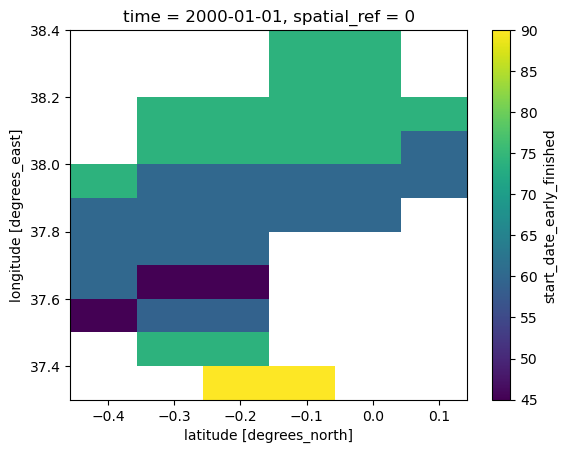

In [49]:
#clipped.isel(time=0)['temperature_2m'].plot()
clipped.isel(time=0)['start_date_early_finished'].plot()

In [15]:
ssrd_tp_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\ssrd_tp_SSA_1999_2008.nc')
xds = rioxarray.open_rasterio('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\vpd_SSA_1999_2008.nc')
xds = xds.rio.write_crs('EPSG:4326')

In [4]:
MODIS_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\SAT_DATA\\MODIS\\Kenya_MODIS_CMG_VIs_2000_2010.nc')

In [8]:
MODIS_data['lon'].max()

<xarray.DataArray 'lon' ()> Size: 8B
array(39.975)

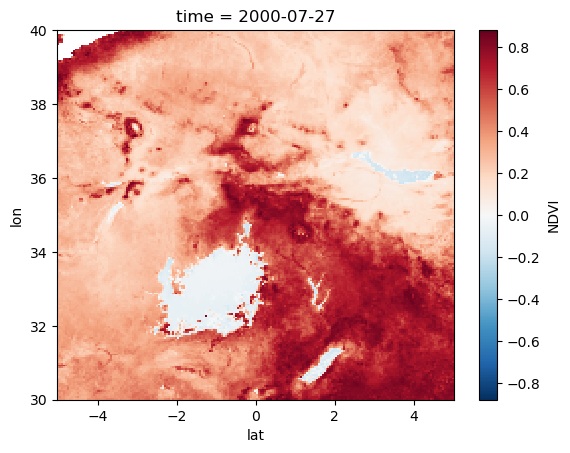

In [6]:
MODIS_data['NDVI'].isel(time=10).plot()

In [16]:
##### REMEMBER TO DO THE 1ST ONE #####
for region_index in list(range(21)) + list(range(22, 50)):
    print(region_index)
    adm1_name = yield_data_mean.iloc[region_index, 1]
    print(adm1_name)
    clipped = xds.rio.clip(yield_data_mean.iloc[[region_index], :].geometry.values, yield_data_mean.crs, all_touched = True, drop=True)#adm_data.iloc[10, :].geometry.exterior.coords
    clipped.to_netcdf(f'C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\ERA5\\Kenya\\vpd\\{adm1_name}_1999_2008.nc')

    #print(len(clipped.values[~np.isnan(clipped.values)]))
    #clipped2 = xds['t2m'].isel(time=10).rio.clip(yield_data_mean.iloc[[region_index], :].geometry.values, yield_data_mean.crs, all_touched = True, drop=False)#adm_data.iloc[10, :].geometry.exterior.coords
    #if len(clipped2.values[~np.isnan(clipped2.values)]) != len(clipped.values[~np.isnan(clipped.values)]):
    #    print(clipped2.values[~np.isnan(clipped2.values)])

0
Baringo
1
Bomet
2
Bungoma
3
Busia
4
Elgeyo-Marakwet
5
Embu
6
Garissa
7
Homa Bay
8
Isiolo
9
Kajiado
10
Kakamega
11
Kericho
12
Kiambu
13
Kiambu
14
Kilifi
15
Kirinyaga
16
Kisii
17
Kisumu
18
Kitui
19
Kwale
20
Laikipia
22
Machakos
23
Makueni
24
Makueni
25
Mandera
26
Marsabit
27
Meru
28
Migori
29
Mombasa
30
Murang'a
31
Nairobi
32
Nakuru
33
Nandi
34
Narok
35
Nyamira
36
Nyandarua
37
Nyeri
38
Samburu
39
Siaya
40
Taita Taveta
41
Tana River
42
Tharaka Nithi
43
Trans Nzoia
44
Turkana
45
Uasin Gishu
46
Vihiga
47
Vihiga
48
Wajir
49
West Pokot


In [69]:
adm_data.iloc[10, 15].to_json

AttributeError: 'Polygon' object has no attribute 'to_json'

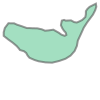

In [93]:
adm_data.iloc[10, :].geometry

In [16]:
ShapeMask = rasterio.features.geometry_mask(adm_data.iloc[0],
                                      out_shape=(len(xds['lat']), len(xds['lat'])),
                                      transform=xds.geobox.transform,
                                      invert=True)
ShapeMask = xr.DataArray(ShapeMask , dims=("y", "x"))

KeyError: "No variable named 'lat'. Variables on the dataset include ['x', 'y', np.str_('time'), 'spatial_ref', 't2m', 't2max', 't2min']"